In [9]:
sub = '01'
data_root = '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics'

In [29]:
from utils_nb import *
from glob import glob
import os
from fnmatch import fnmatch

In [56]:
def prep_data_tempInt(subnrs, sesnrs, runnrs, task='SJ', root = 'TempInt_pilot', framerate = 1/120, verbose = 0,
                     return_paths = False, data_paths = None):
    """
    goes through root folder, should be bids-like, selects all data for the
    given sub-ses-run-task combination
    
    one just processing the events.tsv and the other one managing the files,
    add sigmoid and gaussian fits
    """
    # init result df lists, to become columns
    soas = [] # stimulus onset asynchrony
    resps = [] # responses
    subs = [] # subject
    sessions = []
    runs = []
    which_first = [] # A or V first?
    
    # select data
    if data_paths is None:
        data_paths = select_data_tempInt(subnrs, sesnrs, runnrs, root = root, task = task, verbose = 0)

    for path in data_paths:
        # load run data
        dat = pd.read_csv(path, sep='\t')
        
        # unpack sub, ses, run from string
        bids_dict = parse_bids_filename(path)
        subnr = bids_dict['sub']
        sesnr = bids_dict['ses']
        runnr = bids_dict['run']
                    
        for trial in dat.trial_nr.unique():    
            # index trial
            trial_df = dat[dat.trial_nr == trial]
            soa = trial_df.soa.iloc[0]

            if task == 'SJ':
                # process SJ
                try:
                    # getting response in response period phase 3
                    response = trial_df[(trial_df.event_type == 'response') & (trial_df.phase == 3)].response.values[0]
                except IndexError:
                    response = None

                # synchonous is coded as 1
                response = 1 if response == 'synchronous' else 0
                resps.append(response)

            else:
                # process TOJ
                try:
                    # getting response in response period phase 3
                    response_correct = trial_df[(trial_df.event_type == 'response') & (trial_df.phase == 3)].correct.values[0]
                except IndexError:
                    response_correct = None

                # correct is coded as 1
                resps.append(response_correct)

            first = trial_df.order.iloc[0][0] # which stimulus type was first, derived from tial type 'AV'/'VA'
            soa = soa if first == 'A' else -soa # making soas for visual first negative

            soas.append(soa)
            subs.append(subnr)
            sessions.append(sesnr)
            runs.append(runnr)
            which_first.append(first)
    
    # make df
    resps_df = pd.DataFrame({'soa_f' : soas, 'neg_soa_f': [-soa for soa in soas], 'soa_ms': [soa*framerate*1000 for soa in soas], 
                             'neg_soa_ms': [-soa*framerate*1000 for soa in soas],
                             'response' : resps, 'subject': subs, 'session':sessions, 'run':runs, 'first':which_first})

    # flipped response coding for V-first trials
    comb_soas = []
    responses_flipped = []

    for i, row in resps_df.iterrows():
        
        if row['first'] == 'V': 
            comb_soas.append(row['neg_soa_f'])
            # flip response
            if row['response'] == 0.0:
                responses_flipped.append(1.0)
            else:
                responses_flipped.append(0.0)

        else:
            comb_soas.append(row['soa_f'])
            responses_flipped.append(row['response'])
            
    resps_df['comb_soa_f'] = comb_soas
    resps_df['comb_soa_ms'] = [comb_soa *framerate*1000 for comb_soa in comb_soas]
    resps_df['responses_flipped'] = responses_flipped
    
    if return_paths:
        return resps_df, data_paths
    else:
        return resps_df

In [47]:
# grab files
paths = []
events_paths = []
edf_paths = []
sj_paths = []
toj_paths = []
sd_paths = []
tr_paths = []

for ses in ['00', '01', '02', '03']:
    ses_paths = glob(os.path.join(data_root, f'sub-{sub}', f'ses-{ses}', '*'))

    tr_paths += [path for path in ses_paths if ('TempRep' in path)]
    sj_paths += [path for path in ses_paths if ('TempIntSJ' in path)]
    toj_paths += [path for path in ses_paths if ('TempIntTOJ' in path)]
    sd_paths += [path for path in ses_paths if  ('SigDet' in path)]
    
    print(f'found {len(ses_paths)} files for ses-{ses}')
    events_paths += [path for path in ses_paths if 'event' in path]
    edf_paths += [path for path in ses_paths if 'edf' in path]
    
    paths += ses_paths
#     print(sd_paths)

# print([path.split('/')[-1] for path in paths if 'events' in path])
print(paths)
sj_paths

found 0 files for ses-00
found 8 files for ses-01
found 0 files for ses-02
found 0 files for ses-03
['/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempRep_run-01.edf', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01.edf', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempRep_run-01_events.tsv', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntTOJ_run-01.edf', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntTOJ_run-01_events.tsv', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01_events.tsv', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01.edf', '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01_events.tsv']

['/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01_events.tsv']

(array([-0.16973993, 86.94289636]),
 <Figure size 432x288 with 1 Axes>,
 <AxesSubplot:>)

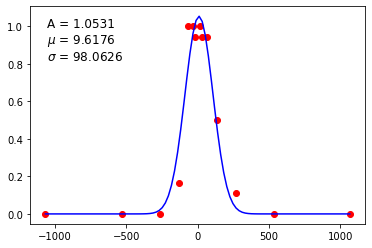

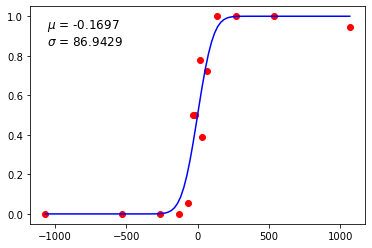

In [60]:
sj_events = [path for path in paths if ('TempIntSJ' in path) and ('events' in path)]
gaussian_init = {'A': 1,'$\mu$':0, '$\sigma$':200} # gaussian
cumnorm_init = {'$\mu$':0, '$\sigma$':200} # cumulative gaussian

data_sj = prep_data_tempInt(None, None, None, task='SJ', root = None, framerate = 1/120, verbose = 0,
                     return_paths = False, data_paths = sj_events)
mean_response = data_sj.groupby(['subject', 'soa_ms', 'session', 'run'])['response'].mean().reset_index()
mean_response.columns = ['subject', 'soa_ms', 'session', 'run', 'mean_response']

quick_fit(mean_response.soa_ms, mean_response.mean_response, gaussian, gaussian_init, plot = True)

toj_events = [path for path in paths if ('TempIntTOJ' in path) and ('events' in path)]
data_toj = prep_data_tempInt(None, None, None, task='TOJ', root = None, framerate = 1/120, verbose = 0,
                     return_paths = False, data_paths = toj_events)
mean_response = data_toj.groupby(['subject', 'soa_ms', 'session', 'run'])['responses_flipped'].mean().reset_index()
mean_response.columns = ['subject', 'soa_ms', 'session', 'run', 'mean_response']

quick_fit(mean_response.soa_ms, mean_response.mean_response, cumulative_normal, cumnorm_init, plot = True)


In [43]:
sd_paths

[]

In [36]:
ls = ['sub-01_ses-01_task-TempRep_run-03_events.tsv', 'sub-01_ses-01_task-TempRep_run-02_events.tsv', 'sub-01_ses-01_task-TempRep_run-01_events.tsv']
ls.sort()
ls

['sub-01_ses-01_task-TempRep_run-01_events.tsv',
 'sub-01_ses-01_task-TempRep_run-02_events.tsv',
 'sub-01_ses-01_task-TempRep_run-03_events.tsv']

In [17]:
glob(os.path.join(data_root, f'sub-{sub}', f'ses-01', '*'))

['/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempRep_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempRep_run-01_events.tsv',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntTOJ_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntTOJ_run-01_events.tsv',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-SigDet_run-01_events.tsv',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01.edf',
 '/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01/sub-01_ses-01_task-TempIntSJ_run-01_events.tsv']

In [14]:
glob('/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01')

['/home/funk/repos/sm-DN_tasks/data/TEST/psychophysics/sub-01/ses-01']

In [3]:
select_data_tempInt([sub], ['00', '01', '02', '03'], ['01'])

Not found TempInt_pilot/sub-01/ses-00/sub-01_ses-00_task-TempInt_run-01_events.tsv
Not found TempInt_pilot/sub-01/ses-01/sub-01_ses-01_task-TempInt_run-01_events.tsv
Not found TempInt_pilot/sub-01/ses-02/sub-01_ses-02_task-TempInt_run-01_events.tsv
Not found TempInt_pilot/sub-01/ses-03/sub-01_ses-03_task-TempInt_run-01_events.tsv


[]